In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [151]:
df = pd.read_csv('df_total_sp.csv')
df = df.drop(columns = ['SG_UF','FEBRE', 'NAUSEA', 'DOR_COSTAS', 'CEFALEIA', 'LACO', 'DOR_RETRO'])

In [152]:
df

,NU_IDADE_N,CRITERIO,MIALGIA,EXANTEMA,VOMITO,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,CHIK
0,37.0,EpiClinico,0,0,0,0,0,0,0,0,0
1,63.0,Laboratorial,0,0,0,0,0,0,0,0,0
2,72.0,EpiClinico,1,0,0,0,0,0,0,0,0
3,21.0,EpiClinico,1,0,0,0,1,1,0,0,0
4,72.0,Laboratorial,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1761395,22.0,Laboratorial,1,1,1,0,1,0,0,0,1
1761396,21.0,Laboratorial,1,1,1,0,0,0,0,0,1
1761397,54.0,Laboratorial,1,0,1,0,0,0,0,0,1
1761398,67.0,Laboratorial,1,0,0,0,0,1,0,0,1


In [153]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico'] 
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO'])
df_epi = df_epi.drop(columns = ['CRITERIO'])

In [154]:
df_lab.shape

(857416, 10)

In [155]:
df_lab = df_lab.drop_duplicates()

In [156]:
df_lab.shape

(16701, 10)

### Train-test split

In [157]:
X = df_lab.iloc[:,0:9]
y = df_lab.iloc[:,9]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [158]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (6680,) 898 5782
Test:  (5010,) 673 4337
Validation:  (5011,) 673 4338


### Random Forest Tuning - Random Search

In [72]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Balanced weights
class_types = [None, 'balanced']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'criterion': ['gini', 'entropy', 'log_loss'],
               'max_features': ['sqrt'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_types
               }

In [73]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'roc_auc',
                               cv = 5, 
                               verbose = 3,
                               random_state=0,
                               n_jobs = -1)

In [15]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [37]:
rf_random.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=300)

In [39]:
rf_random.best_score_

0.7925993205630029

### XGBoost Tuning - Random Search

In [159]:
max_depth = [int(x) for x in np.linspace(1, 15, num = 10)]
min_child_weight = [1, 5, 10, 50, 100, 200]
subsample = [0.5, 0.75, 1]
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
colsample_bytree = [0.5, 0.75, 1]
colsample_bylevel = [0.5, 0.75, 1]
scale_pos_weight = [None, 10, 20, np.sqrt(20)]

# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'learning_rate': learning_rate,
               'scale_pos_weight': scale_pos_weight,
               'colsample_bytree': colsample_bytree,
               'colsample_bylevel': colsample_bylevel
               }

In [160]:
rf_random = RandomizedSearchCV(estimator = XGBClassifier(nthread = 8),
                               param_distributions = random_grid,
                               n_iter = 200,
                               scoring = 'roc_auc',
                               cv = 5, 
                               verbose = 3,
                               random_state=0,
                               n_jobs = -1)

In [161]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=200, n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.5, 0.75, 1],
                                        'colsample_bytree': [0.5, 0.75, 1],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.05, 0.1, 0.5, 1],
                                        'max_depth': [1, 2, 4, 5, 7, 8, 10, 11,
                                                      13, 15],
                                        'min_child_weight': [1, 5, 10, 50, 100,
                                                             200],
                                        'scale_pos_weight': [None, 10, 20,
                                                             4.47213595499958],
                                        'subsample': [0.5, 0.75, 1]},
                   random_state=0, scoring='roc_auc', verbose=3)

In [162]:
rf_random.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=8,
              num_parallel_tree=None, ...)

In [163]:
rf_random.best_estimator_.subsample

1

In [164]:
rf_random.best_score_

0.8291378080941522

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

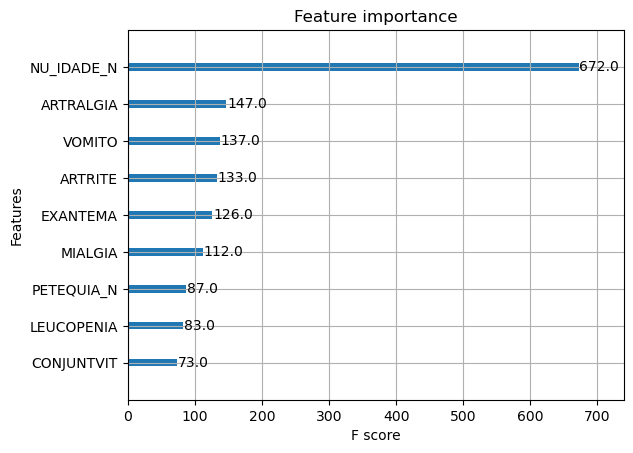

In [165]:
plot_importance(rf_random.best_estimator_, importance_type='weight', max_num_features=10)

### Logistic regression - Randomized Search CV

In [112]:
penalty = ['l2', 'l1']
C = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.75, 1]
class_weight = [None, 'balanced']

# Create the random grid
random_grid = {'penalty': penalty,
               'C': C,
               'class_weight': class_weight
               }

In [113]:
rf_random = RandomizedSearchCV(estimator = LogisticRegression(solver = 'liblinear'),
                               param_distributions = random_grid,
                               n_iter = 500,
                               scoring = 'roc_auc',
                               cv = 10, 
                               verbose = 3,
                               random_state=0,
                               n_jobs = -1)

In [114]:
rf_random.fit(X_train, y_train)

The total space of parameters 32 is smaller than n_iter=500. Running 32 iterations. For exhaustive searches, use GridSearchCV.


Fitting 10 folds for each of 32 candidates, totalling 320 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(solver='liblinear'),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.005, 0.01, 0.05, 0.1,
                                              0.5, 0.75, 1],
                                        'class_weight': [None, 'balanced'],
                                        'penalty': ['l2', 'l1']},
                   random_state=0, scoring='roc_auc', verbose=3)

In [116]:
rf_random.best_score_

0.7815944637658985

In [117]:
rf_random.best_estimator_

LogisticRegression(C=0.5, solver='liblinear')